# Long Short Term Memory for Cloud Learning for Daily Predictions

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.optimizers import Adam

### Importing Dataset

In [2]:
file_path = 'final-dataset.csv'
data = pd.read_csv(file_path)

### Preprocessing Dataset

In [3]:
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

In [4]:
# Aggregate to daily data
daily_data = data.resample('D').mean().dropna()

#### Creating Lag Features for Temporal Patterns

In [5]:
# Feature Engineering: lag features
for i in range(1, 11):  # Adding lag features for 10 days
    daily_data[f'PM2.5_lag{i}'] = daily_data['PM2.5'].shift(i)
daily_data = daily_data.dropna()

#### Scaling Features and Target

In [6]:
# Select the features and target
features = daily_data[['Year', 'Month', 'Day'] + [f'PM2.5_lag{i}' for i in range(1, 11)]]
target = daily_data['PM2.5']

In [7]:
# Scaling the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

#### Train Test Split

In [8]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled,
                                                    target_scaled,
                                                    test_size=0.2,
                                                    random_state=42)

In [9]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Building Hybrid CNN-LSTM Model for Daily Predictions

In [10]:
# Building the Hybrid LSTM-CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

#### Training Model

In [11]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [12]:
history = model.fit(X_train, y_train, epochs=150, batch_size=16,
                    validation_data=(X_test, y_test),
                    verbose=1, shuffle=False)

Epoch 1/150
5/5 [==============================] - 1s 63ms/step - loss: 0.0899 - val_loss: 0.0547
Epoch 2/150
5/5 [==============================] - 0s 13ms/step - loss: 0.0497 - val_loss: 0.0714
Epoch 3/150
5/5 [==============================] - 0s 15ms/step - loss: 0.0501 - val_loss: 0.0584
Epoch 4/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0375 - val_loss: 0.0488
Epoch 5/150
5/5 [==============================] - 0s 14ms/step - loss: 0.0336 - val_loss: 0.0472
Epoch 6/150
5/5 [==============================] - 0s 15ms/step - loss: 0.0367 - val_loss: 0.0484
Epoch 7/150
5/5 [==============================] - 0s 15ms/step - loss: 0.0338 - val_loss: 0.0511
Epoch 8/150
5/5 [==============================] - 0s 14ms/step - loss: 0.0289 - val_loss: 0.0506
Epoch 9/150
5/5 [==============================] - 0s 17ms/step - loss: 0.0313 - val_loss: 0.0472
Epoch 10/150
5/5 [==============================] - 0s 10ms/step - loss: 0.0283 - val_loss: 0.0464
Epoch 11/150
5/5 [=

#### Making Predictions

In [13]:
# Making predictions for the test set
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 241ms/step


In [14]:
# Inverse scaling to get actual values
y_test_actual = scaler_target.inverse_transform(y_test)
y_pred_actual = scaler_target.inverse_transform(y_pred)

### Evaluating Model Performance

In [15]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

In [16]:
# Print metrics
print(f'Daily MSE: {mse}')
print(f'Daily RMSE: {rmse}')
print(f'Daily MAE: {mae}')
print(f'Daily R2: {r2}')

Daily MSE: 663.0279272378095
Daily RMSE: 25.74932867547831
Daily MAE: 21.1885053952535
Daily R2: 0.31213939741502195


### Visual Plot for Actual and Predicted Data Points

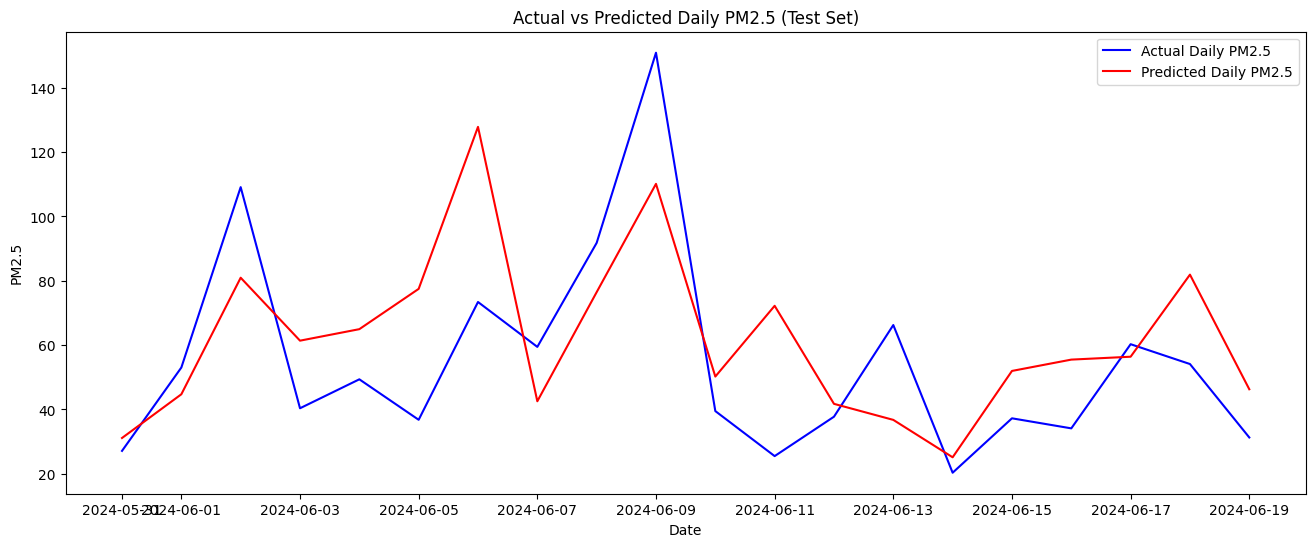

In [18]:
# Plot actual vs predicted daily values for the test set
plt.figure(figsize=(16, 6))
plt.plot(daily_data.index[-len(y_test_actual):], y_test_actual, color='blue', label='Actual Daily PM2.5')
plt.plot(daily_data.index[-len(y_test_actual):], y_pred_actual, color='red', label='Predicted Daily PM2.5')
plt.title('Actual vs Predicted Daily PM2.5 (Test Set)')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()